# Structuring: Hierarchical Clustering Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset loading

In [2]:
# Load the dataset
df = pd.read_csv('Structuring-data-simple.csv', sep=';', index_col=0)

# Handle missing values - replace with median of each determinant
df_cleaned = df.fillna(df.median())

# For clustering determinants, we need determinants as rows and participants as columns
df_for_clustering = df_cleaned.T  # Now rows = determinants, columns = participants

print("\nData for clustering shape (determinants x participants):", df_for_clustering.shape)
print("Determinants (rows):", df_for_clustering.index.tolist())


Data for clustering shape (determinants x participants): (29, 90)
Determinants (rows): ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29']


### Clustering

Feature matrix shape: (29, 2)

Features:
mean_response: General tendency (1-7)
rwg: Agreement level (higher = more agreement, lower = more disagreement)


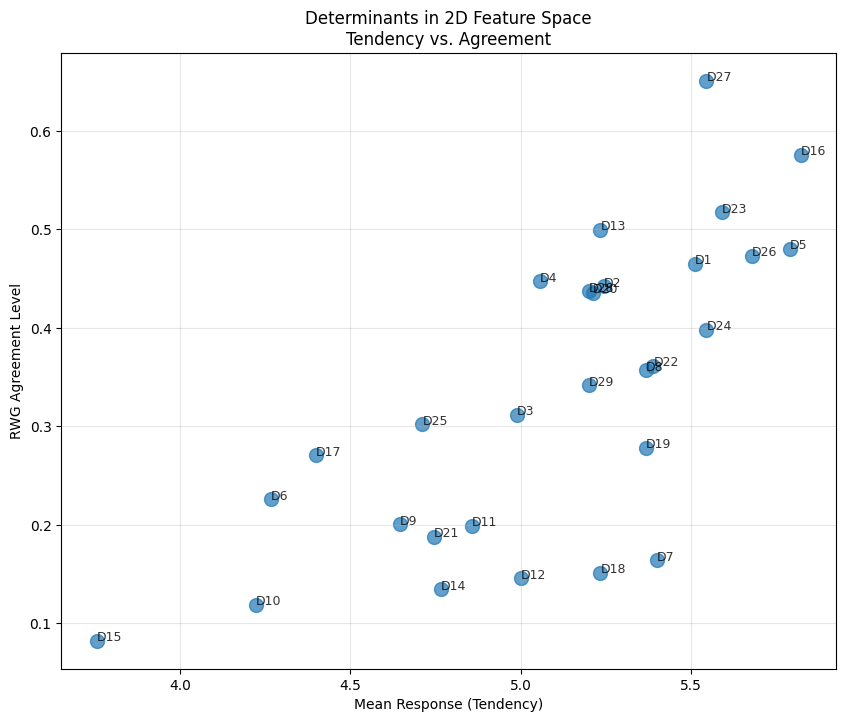

In [4]:
def calculate_rwg_agreement(data):
    """Calculate rwg (within-group inter-rater agreement) statistic
    
    rwg = 1 - (Observed Group Variance / Expected Random Variance)
    
    Expected Random Variance for 7-point scale = (7^2 - 1) / 12 = 4.0
    """
    
    # Remove missing values
    valid_data = data.dropna()
    
    if len(valid_data) == 0:
        return np.nan
    
    # Expected random variance for 7-point scale (1-7)
    # Formula: (k^2 - 1) / 12 where k = number of scale points
    expected_random_variance = (7**2 - 1) / 12  # = 4.0
    
    # Observed group variance
    observed_variance = np.var(valid_data, ddof=1)
    
    # Calculate rwg
    if expected_random_variance == 0:
        rwg = np.nan
    else:
        rwg = 1 - (observed_variance / expected_random_variance)
    
    return rwg

def create_mean_rwg_features(df_for_clustering):
    """
    Create 2 key features: mean (tendency) and rwg (agreement)
    """
    features = {}
    
    for det in df_for_clustering.index:
        responses = df_for_clustering.loc[det].dropna()
        
        if len(responses) == 0:
            continue
            
        # Feature 1: General tendency (mean)
        mean_resp = responses.mean()
        
        # Feature 2: Agreement level (rwg)
        rwg_score = calculate_rwg_agreement(responses)
        
        features[det] = {
            'mean_response': mean_resp,      # Tendency: 1-7 scale
            'rwg': rwg_score                 # Agreement: Higher = more agreement
        }
    
    return pd.DataFrame(features).T

# Create mean-rwg feature matrix
feature_matrix = create_mean_rwg_features(df_for_clustering)
print("Feature matrix shape:", feature_matrix.shape)
print("\nFeatures:")
print("mean_response: General tendency (1-7)")
print("rwg: Agreement level (higher = more agreement, lower = more disagreement)")

# Visualize the 2D feature space
plt.figure(figsize=(10, 8))
plt.scatter(feature_matrix['mean_response'], feature_matrix['rwg'], 
           alpha=0.7, s=100)

# Add determinant labels
for det in feature_matrix.index:
    plt.annotate(det, (feature_matrix.loc[det, 'mean_response'], 
                      feature_matrix.loc[det, 'rwg']), 
                fontsize=9, alpha=0.8)

plt.xlabel('Mean Response (Tendency)')
plt.ylabel('RWG Agreement Level')
plt.title('Determinants in 2D Feature Space\nTendency vs. Agreement')
plt.grid(True, alpha=0.3)
plt.show()



In [5]:
# Now cluster based on these 2 features
n_clusters = 4  # Changed from 5 to 4

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

# Perform clustering
clustering = AgglomerativeClustering(
    n_clusters=n_clusters, 
    linkage='average',
    metric='euclidean'
)
cluster_labels_features = clustering.fit_predict(features_scaled)

# Create cluster assignment dataframe
cluster_df_features = pd.DataFrame({
    'Determinant': feature_matrix.index,
    'Cluster': cluster_labels_features + 1
})


=== CLUSTER 1 ===
Determinants: ['D1', 'D2', 'D4', 'D5', 'D8', 'D13', 'D16', 'D19', 'D20', 'D22', 'D23', 'D24', 'D26', 'D27', 'D28', 'D29']
Tendency (Mean): 5.42
Agreement (RWG): 0.45
Cluster Description: Medium tendency with Medium agreement

=== CLUSTER 2 ===
Determinants: ['D6', 'D10', 'D17']
Tendency (Mean): 4.30
Agreement (RWG): 0.21
Cluster Description: Medium tendency with Low agreement

=== CLUSTER 3 ===
Determinants: ['D3', 'D7', 'D9', 'D11', 'D12', 'D14', 'D18', 'D21', 'D25']
Tendency (Mean): 4.93
Agreement (RWG): 0.20
Cluster Description: Medium tendency with Low agreement

=== CLUSTER 4 ===
Determinants: ['D15']
Tendency (Mean): 3.76
Agreement (RWG): 0.08
Cluster Description: Low tendency with Low agreement


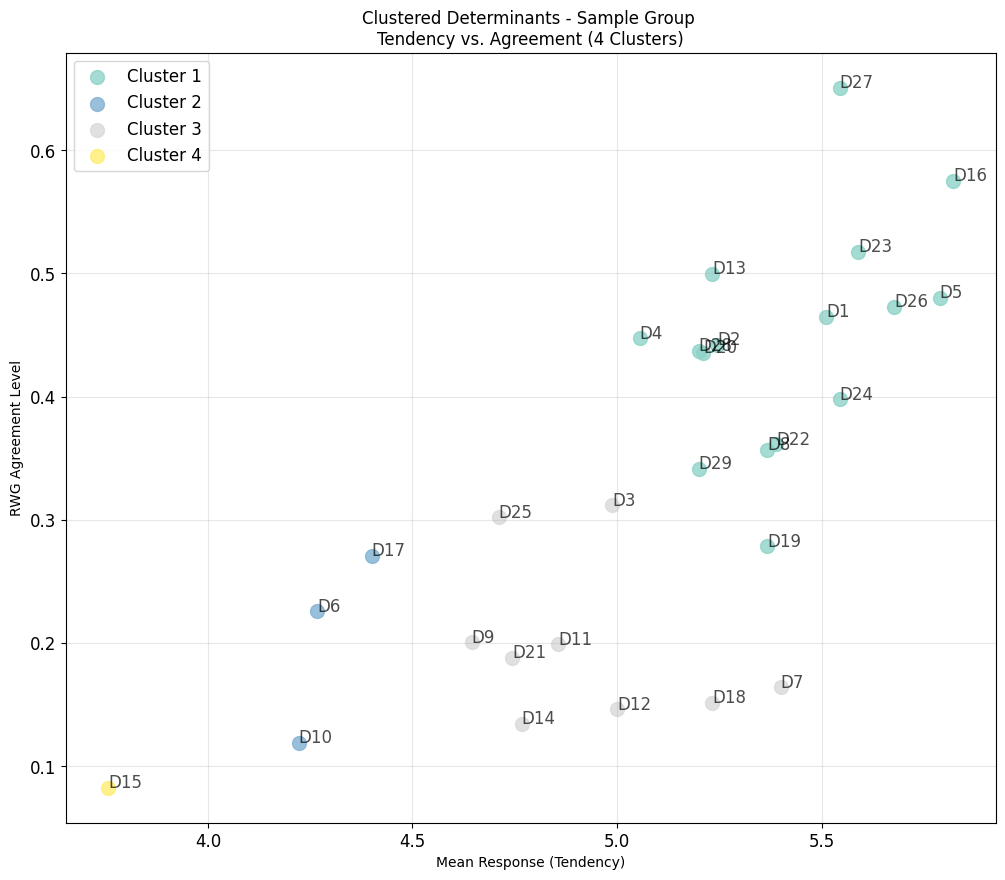

In [6]:
# Analyze what makes each cluster unique
def analyze_mean_rwg_clusters(feature_matrix, cluster_df_features, n_clusters):
    for cluster_id in range(1, n_clusters + 1):
        cluster_determinants = cluster_df_features[cluster_df_features['Cluster'] == cluster_id]['Determinant'].tolist()
        cluster_data = feature_matrix.loc[cluster_determinants]
        
        print(f"\n=== CLUSTER {cluster_id} ===")
        print(f"Determinants: {cluster_determinants}")
        
        # Show the 2 key characteristics
        print(f"Tendency (Mean): {cluster_data['mean_response'].mean():.2f}")
        print(f"Agreement (RWG): {cluster_data['rwg'].mean():.2f}")
        
        # Interpret the cluster
        mean_avg = cluster_data['mean_response'].mean()
        rwg_avg = cluster_data['rwg'].mean()
        
        if mean_avg >= 5.5:
            tendency_desc = "High tendency"
        elif mean_avg >= 4:
            tendency_desc = "Medium tendency"
        else:
            tendency_desc = "Low tendency"
            
        if rwg_avg >= 0.7:
            agreement_desc = "High agreement"
        elif rwg_avg >= 0.4:
            agreement_desc = "Medium agreement"
        else:
            agreement_desc = "Low agreement"
            
        print(f"Cluster Description: {tendency_desc} with {agreement_desc}")

# Run the analysis
analyze_mean_rwg_clusters(feature_matrix, cluster_df_features, n_clusters)

# Visualize clusters in the 2D space
plt.figure(figsize=(12, 10))

# Color by cluster
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
for cluster_id in range(1, n_clusters + 1):
    cluster_determinants = cluster_df_features[cluster_df_features['Cluster'] == cluster_id]['Determinant'].tolist()
    cluster_data = feature_matrix.loc[cluster_determinants]
    
    plt.scatter(cluster_data['mean_response'], cluster_data['rwg'], 
               c=[colors[cluster_id-1]], s=100, alpha=0.8, 
               label=f'Cluster {cluster_id}')

# Add determinant labels
for det in feature_matrix.index:
    plt.annotate(det, (feature_matrix.loc[det, 'mean_response'], 
                      feature_matrix.loc[det, 'rwg']), 
                fontsize=12, alpha=0.7)

plt.xlabel('Mean Response (Tendency)')
plt.ylabel('RWG Agreement Level')
plt.title('Clustered Determinants - Sample Group \nTendency vs. Agreement (4 Clusters)')
plt.legend(fontsize=12)
# Control tick label sizes
plt.xticks(fontsize=12)  # X-axis tick labels
plt.yticks(fontsize=12)  # Y-axis tick labels
plt.grid(True, alpha=0.3)
plt.show()
  

results_df = cluster_df_features.copy()
results_df = results_df = results_df.merge(feature_matrix, left_index=True, right_index=True)
results_df = results_df.sort_values('Cluster')


### Silhouette analysis

SILHOUETTE SCORE ANALYSIS
Overall Silhouette Score: 0.410 (GOOD)

Per-Cluster Analysis:
------------------------------
Cluster  Size   Avg Score    Quality     
------------------------------
Cluster 1 16     0.495        GOOD        
Cluster 2 3      0.366        GOOD        
Cluster 3 9      0.318        GOOD        
Cluster 4 1      0.000        FAIR        


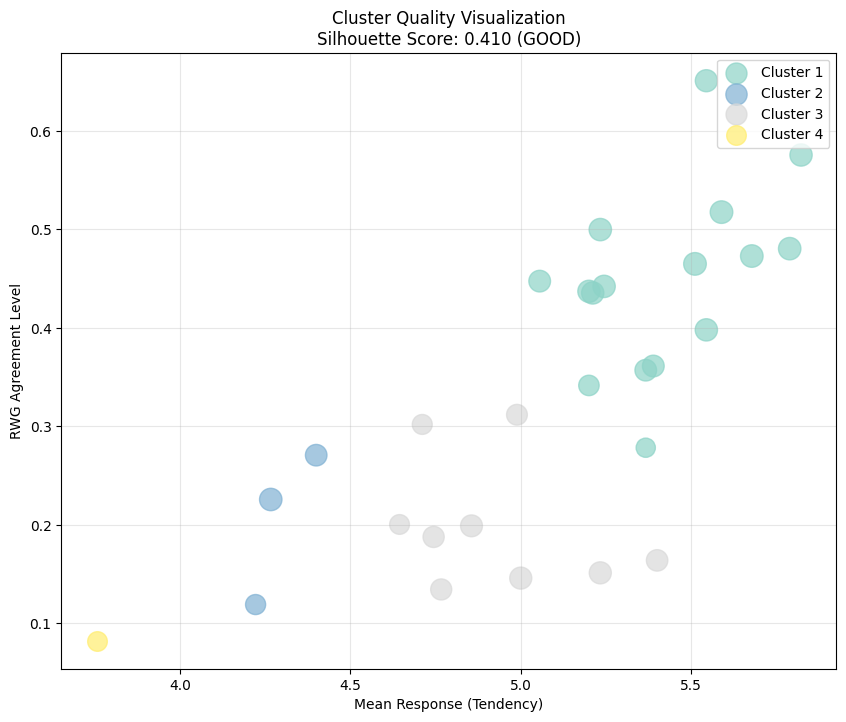


INTERPRETATION:
• Silhouette Score: 0.410
• Quality Level: GOOD
• Point Size: Larger points = better cluster fit


In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# 1. CALCULATE SILHOUETTE SCORES
silhouette_avg = silhouette_score(features_scaled, cluster_labels_features)
silhouette_vals = silhouette_samples(features_scaled, cluster_labels_features)

# 2. CREATE SUMMARY TABLE
print("SILHOUETTE SCORE ANALYSIS")
print("=" * 50)

# Overall score
if silhouette_avg >= 0.5:
    quality = "EXCELLENT"
elif silhouette_avg >= 0.25:
    quality = "GOOD"
elif silhouette_avg >= 0:
    quality = "FAIR"
else:
    quality = "POOR"

print(f"Overall Silhouette Score: {silhouette_avg:.3f} ({quality})")

# Per-cluster scores
print(f"\nPer-Cluster Analysis:")
print("-" * 30)
print(f"{'Cluster':<8} {'Size':<6} {'Avg Score':<12} {'Quality':<12}")
print("-" * 30)

for cluster_id in range(1, n_clusters + 1):
    cluster_indices = np.where(cluster_labels_features == (cluster_id - 1))[0]
    cluster_silhouette = silhouette_vals[cluster_indices]
    avg_score = np.mean(cluster_silhouette)
    
    if avg_score >= 0.5:
        cluster_quality = "EXCELLENT"
    elif avg_score >= 0.25:
        cluster_quality = "GOOD"
    elif avg_score >= 0:
        cluster_quality = "FAIR"
    else:
        cluster_quality = "POOR"
    
    print(f"{'Cluster '+str(cluster_id):<8} {len(cluster_indices):<6} {avg_score:<12.3f} {cluster_quality:<12}")

# 3. SINGLE VISUALIZATION: Feature Space with Silhouette Quality
plt.figure(figsize=(10, 8))

colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

for cluster_id in range(n_clusters):
    cluster_determinants = cluster_df_features[cluster_df_features['Cluster'] == cluster_id + 1]['Determinant'].tolist()
    cluster_data = feature_matrix.loc[cluster_determinants]
    
    # Get silhouette scores for this cluster
    cluster_indices = np.where(cluster_labels_features == cluster_id)[0]
    cluster_silhouette = silhouette_vals[cluster_indices]
    
    # Size points by silhouette score (better fit = larger point)
    sizes = 100 + (cluster_silhouette + 1) * 100
    
    plt.scatter(cluster_data['mean_response'], cluster_data['rwg'], 
               c=[colors[cluster_id]], s=sizes, alpha=0.7, 
               label=f'Cluster {cluster_id + 1}')

plt.xlabel('Mean Response (Tendency)')
plt.ylabel('RWG Agreement Level')
plt.title(f'Cluster Quality Visualization\nSilhouette Score: {silhouette_avg:.3f} ({quality})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. SIMPLE INTERPRETATION
print(f"\nINTERPRETATION:")
print("=" * 50)
print(f"• Silhouette Score: {silhouette_avg:.3f}")
print(f"• Quality Level: {quality}")
print(f"• Point Size: Larger points = better cluster fit")

### Calculate linear relationship between mean score and RWG agreement

LINEAR RELATIONSHIP: Mean Score vs. RWG Agreement
Correlation Analysis:
  Pearson correlation coefficient (r): 0.7279
  R-squared: 0.5299
  P-value: 0.000008
  Significance: Significant (α = 0.05)

Linear Regression:
  Slope: 0.2226
  Intercept: -0.8011
  R-value: 0.7279
  P-value: 0.000008
  Standard error: 0.0404


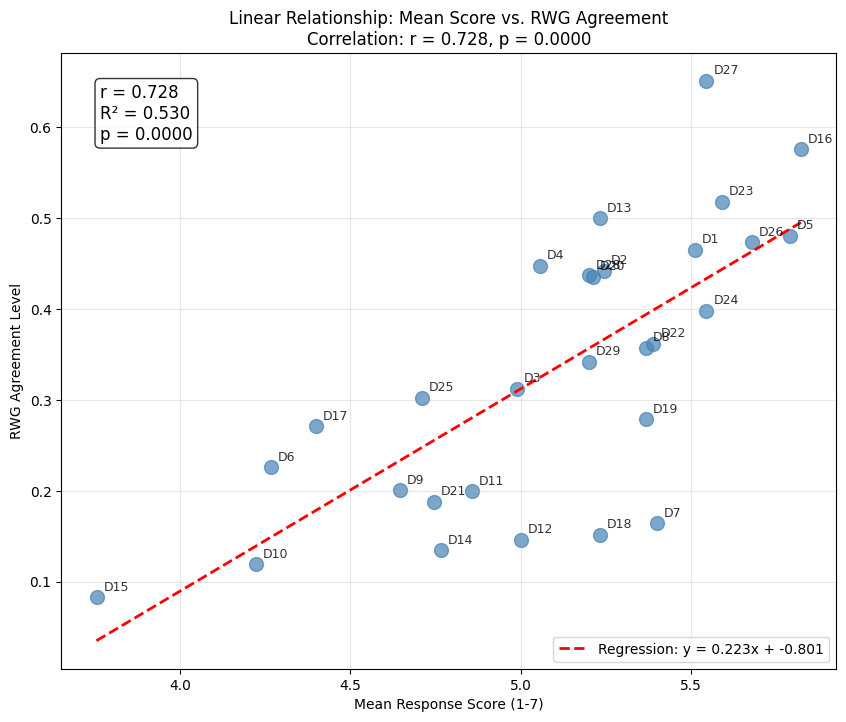


ADDITIONAL STATISTICAL TESTS
Spearman correlation (ρ): 0.7366, p = 0.000005
Kendall's tau (τ): 0.5594, p = 0.559413
95% Confidence Interval for r: [0.4929, 0.8639]

Effect Size Interpretation:
  Correlation strength: Large (|r| = 0.728)

SUMMARY
There is a 0.728 correlation between mean determinant scores and RWG agreement.
This relationship explains 53.0% of the variance in RWG agreement.
The relationship is statistically significant (p = 0.0000).
Effect size is considered large.


In [ ]:

from scipy import stats
import matplotlib.pyplot as plt

print("="*60)
print("LINEAR RELATIONSHIP: Mean Score vs. RWG Agreement")
print("="*60)

# Extract the two variables
mean_scores = feature_matrix['mean_response'].values
rwg_scores = feature_matrix['rwg'].values

# Calculate Pearson correlation coefficient
correlation_coef, p_value = stats.pearsonr(mean_scores, rwg_scores)

# Calculate R-squared
r_squared = correlation_coef ** 2

# Calculate linear regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(mean_scores, rwg_scores)

print(f"Correlation Analysis:")
print(f"  Pearson correlation coefficient (r): {correlation_coef:.4f}")
print(f"  R-squared: {r_squared:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Significance: {'Significant' if p_value < 0.05 else 'Not significant'} (α = 0.05)")

print(f"\nLinear Regression:")
print(f"  Slope: {slope:.4f}")
print(f"  Intercept: {intercept:.4f}")
print(f"  R-value: {r_value:.4f}")
print(f"  P-value: {p_value_reg:.6f}")
print(f"  Standard error: {std_err:.4f}")

# Create scatter plot with regression line
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(mean_scores, rwg_scores, alpha=0.7, s=100, color='steelblue')

# Add determinant labels
for i, det in enumerate(feature_matrix.index):
    plt.annotate(det, (mean_scores[i], rwg_scores[i]), 
                fontsize=9, alpha=0.8, xytext=(5, 5), textcoords='offset points')

# Regression line
x_line = np.linspace(mean_scores.min(), mean_scores.max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', linestyle='--', linewidth=2, 
         label=f'Regression: y = {slope:.3f}x + {intercept:.3f}')

# Add correlation info to plot
plt.text(0.05, 0.95, f'r = {correlation_coef:.3f}\nR² = {r_squared:.3f}\np = {p_value:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Mean Response Score (1-7)')
plt.ylabel('RWG Agreement Level')
plt.title('Linear Relationship: Mean Score vs. RWG Agreement\n' + 
          f'Correlation: r = {correlation_coef:.3f}, p = {p_value:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Additional statistical tests
print(f"\n" + "="*60)
print("ADDITIONAL STATISTICAL TESTS")
print("="*60)

# Spearman correlation (non-parametric)
spearman_corr, spearman_p = stats.spearmanr(mean_scores, rwg_scores)
print(f"Spearman correlation (ρ): {spearman_corr:.4f}, p = {spearman_p:.6f}")

# Kendall's tau (non-parametric)
kendall_tau, kendall_p = stats.kendalltau(mean_scores, rwg_scores)
print(f"Kendall's tau (τ): {kendall_tau:.4f}, p = {kendall_tau:.6f}")

# Confidence intervals for correlation
from scipy.stats import pearsonr
def correlation_confidence_interval(r, n, confidence=0.95):
    """Calculate confidence interval for Pearson correlation"""
    import math
    from scipy.stats import norm
    
    # Fisher's z transformation
    z = 0.5 * math.log((1 + r) / (1 - r))
    
    # Standard error
    se = 1 / math.sqrt(n - 3)
    
    # Critical value
    z_crit = norm.ppf((1 + confidence) / 2)
    
    # Confidence interval
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    
    # Transform back to correlation scale
    r_lower = (math.exp(2 * z_lower) - 1) / (math.exp(2 * z_lower) + 1)
    r_upper = (math.exp(2 * z_upper) - 1) / (math.exp(2 * z_upper) + 1)
    
    return r_lower, r_upper

# Calculate 95% confidence interval
ci_lower, ci_upper = correlation_confidence_interval(correlation_coef, len(mean_scores))
print(f"95% Confidence Interval for r: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Effect size interpretation
print(f"\nEffect Size Interpretation:")
if abs(correlation_coef) >= 0.7:
    effect_size = "Large"
elif abs(correlation_coef) >= 0.5:
    effect_size = "Medium"
elif abs(correlation_coef) >= 0.3:
    effect_size = "Small"
else:
    effect_size = "Negligible"

print(f"  Correlation strength: {effect_size} (|r| = {abs(correlation_coef):.3f})")

# Summary
print(f"\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"There is a {correlation_coef:.3f} correlation between mean determinant scores and RWG agreement.")
print(f"This relationship explains {r_squared:.1%} of the variance in RWG agreement.")
print(f"The relationship is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} (p = {p_value:.4f}).")
print(f"Effect size is considered {effect_size.lower()}.")